# New attempt

Saving data at t = 1.00e-03
Saving data at t = 2.00e-03
Saving data at t = 3.00e-03
Saving data at t = 4.00e-03
Saving data at t = 5.01e-03
Saving data at t = 6.01e-03
Saving data at t = 7.01e-03
Saving data at t = 8.01e-03
Saving data at t = 9.01e-03
Saving data at t = 1.00e-02
Saving data at t = 1.10e-02
Saving data at t = 1.20e-02
Saving data at t = 1.30e-02
Saving data at t = 1.40e-02
Saving data at t = 1.50e-02
Saving data at t = 1.60e-02
Saving data at t = 1.70e-02
Saving data at t = 1.80e-02
Saving data at t = 1.90e-02
Saving data at t = 2.00e-02
Saving data at t = 2.10e-02
Saving data at t = 2.20e-02
Saving data at t = 2.30e-02
Saving data at t = 2.40e-02
Saving data at t = 2.50e-02
Saving data at t = 2.60e-02
Saving data at t = 2.70e-02
Saving data at t = 2.80e-02
Saving data at t = 2.90e-02
Saving data at t = 3.00e-02
Saving data at t = 3.10e-02
Saving data at t = 3.20e-02
Saving data at t = 3.30e-02
Saving data at t = 3.40e-02
Saving data at t = 3.50e-02
Saving data at t = 3

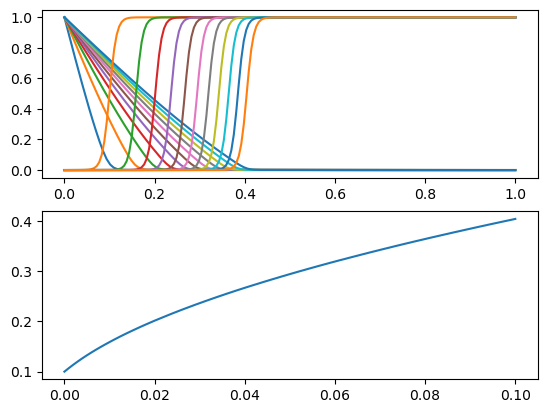

In [1]:
import numpy as np
from scipy.special import erf
from scipy.optimize import root_scalar
from scipy.interpolate import interp1d

# Parameters
# ==========
# Number of grid points
Nphi = 181 + 1
NT = 128 + 1
# Size of domain in x
Lx = 1.0

# x phiii
# x-coordinate vector
x_phi = np.linspace(0, Lx, Nphi)
# Grid spacing in x
dx_phi = x_phi[1] - x_phi[0]

# x t
# x-coordinate vector

# x_t = np.linspace(0, Lx, NT)
x_t = np.linspace(0, Lx, NT)
# Grid spacing in x
dx_t = x_t[1] - x_t[0]

# Phase-field parameters # Issues atm
As = 128
eps = (1/128)
A = As*eps
D = 1.2/A

# Similarity solution parameter
def f_lam(x):
    return np.sqrt(np.pi)*x*np.exp(x**2)*erf(x) - 1.0
lam = root_scalar(f_lam, bracket=[0, 1]).root

# Initial interface position
h = 0.1
# Initial conditions for phi 
phi = 0.5*(1 + np.tanh((x_phi - h)/(2*eps)))

# Initial conditions for T
T = np.zeros(x_t.size)

T_1plus = np.log(2 * np.cosh((x_t[x_t>h] - h) / (2 * eps))) - (x_t[x_t>h] - h) / (2 * eps)
T_1minus = np.log(1+np.exp((x_t[x_t<h]-h)/eps))
Sv0 = (2*lam**2)/h

T[x_t<h] = 1.0 - erf(lam*x_t[x_t<h]/h)/erf(lam) + eps*Sv0*T_1minus # T0 + T1_minus
T[x_t>h] = eps*Sv0*T_1plus # T1_plus
dphi = np.zeros(x_phi.size)

# Storage arrays for time evolution
phi_save = np.zeros((Nphi, 101))
T_save = np.zeros((NT, 101))
phi_save[:, 0] = phi
T_save[:, 0] = T

# Time-stepping parameters
simtime = 0.0   # Current simulation time

dt = 0.8*(dx_phi)**2 # Time step
#dt = 104.8576*(dx_phi)**3

t_end = 0.1     # End simulation time
dt_save = t_end/100 # Interval for saving data

def D2(kappa, Nx):
    """
    Construct a second derivative matrix with empty
    top and bottom rows free for boundary conditions.
    Second derivative is multiplied by a constant `kappa`.
    """
    x = np.linspace(0, Lx, Nx)
    dx = x[1] - x[0]
    kappa = kappa/dx**2
    M = np.zeros((Nx, Nx))
    for i in range(1, Nx-1):
        M[i, i-1:i+2] = np.array([1, -2, 1])*kappa
    return M

# Construct left-hand side matrices
D2phi = D2(D, Nphi)
Lphi = np.eye(Nphi) - 0.5*dt*D2phi
D2T = D2(1.0, NT)
LT = np.eye(NT) - 0.5*dt*D2T

# Temporary arrays for time-stepping
rhs_T = np.zeros(NT)
rhs_phi = np.zeros(Nphi)

dphi = np.zeros(x_phi.size)
De2 = D/eps**2

iLphi = np.linalg.inv(Lphi)
iLT = np.linalg.inv(LT)

def step_time():
    global phi, T
    interp_func = interp1d(x_t, T, kind='linear') # Interpolate T grid on to phi grid 
    T_interp = interp_func(x_phi) 
    rhs_phi[:] = dt*D2phi@phi + dt*(
        -De2*phi*(1 - phi)*(1 - 2*phi + A*T_interp) # Compute b
    )
    rhs_phi[0] = 0.0 # Enforce boundary condition
    dphi[:] = iLphi@rhs_phi # M^{-1}b
    phi += dphi
    interp_func2 = interp1d(x_phi, dphi, kind='linear') # Interpolate phi grid on to T grid 
    dPhi_interp = interp_func2(x_t) 
    rhs_T[:] = T + 0.5*dt*D2T@T + dPhi_interp # Compute d
    rhs_T[0] = 1.0 # Enforce boundary condition
    T[:] = iLT@rhs_T # C^{-1}b
    return

import time

t1 = time.time()
# Main loop
while simtime < t_end:
    step_time()
    simtime += dt
    if simtime % dt_save < dt:
        print('Saving data at t = %.2e' % simtime)
        phi_save[:, int(simtime/dt_save)] = phi
        T_save[:, int(simtime/dt_save)] = T
t2 = time.time()
print('Elapsed time: %.2f seconds' % (t2 - t1))

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2)
ax = axs[0]
ax.plot(x_t, T_save[:,::10])
ax.plot(x_phi, phi_save[:,::10])

h_num = np.array([np.interp(0.5, phi_save[:,i], x_phi) for i in range(phi_save.shape[1])])
ax = axs[1]
ax.plot(np.linspace(0, t_end, phi_save.shape[1]), h_num)
plt.show()

#T_save[:, 0]

In [20]:
print(dt/(dx_phi)**2)
print(dt/(eps)**2)

print(dt/(dx_phi)**3)
print((dt/(eps)**3))


0.7999999999999999
0.0705594823455946
344.8
9.031613740236109


In [22]:
#np.savez('phimewT_N152_eps128', T=T_save, phi=phi_save, dt=dt, eps=eps, h_num=h_num)

# Cubic Interpolation

Saving data at t = 1.00e-03
Saving data at t = 2.00e-03
Saving data at t = 3.00e-03
Saving data at t = 4.00e-03
Saving data at t = 5.00e-03
Saving data at t = 6.01e-03
Saving data at t = 7.01e-03
Saving data at t = 8.01e-03
Saving data at t = 9.01e-03
Saving data at t = 1.00e-02
Saving data at t = 1.10e-02
Saving data at t = 1.20e-02
Saving data at t = 1.30e-02
Saving data at t = 1.40e-02
Saving data at t = 1.50e-02
Saving data at t = 1.60e-02
Saving data at t = 1.70e-02
Saving data at t = 1.80e-02
Saving data at t = 1.90e-02
Saving data at t = 2.00e-02
Saving data at t = 2.10e-02
Saving data at t = 2.20e-02
Saving data at t = 2.30e-02
Saving data at t = 2.40e-02
Saving data at t = 2.50e-02
Saving data at t = 2.60e-02
Saving data at t = 2.70e-02
Saving data at t = 2.80e-02
Saving data at t = 2.90e-02
Saving data at t = 3.00e-02
Saving data at t = 3.10e-02
Saving data at t = 3.20e-02
Saving data at t = 3.30e-02
Saving data at t = 3.40e-02
Saving data at t = 3.50e-02
Saving data at t = 3

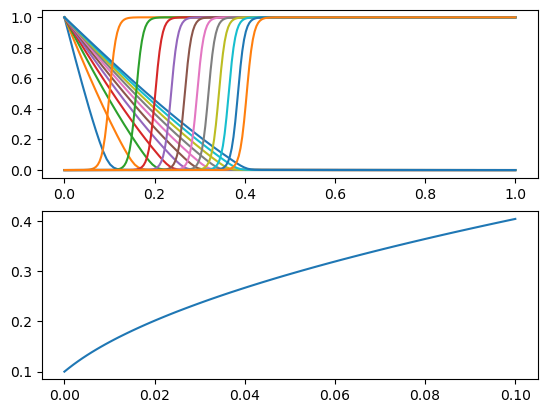

In [25]:
import numpy as np
from scipy.special import erf
from scipy.optimize import root_scalar
#from scipy.interpolate import interp1d
from scipy.interpolate import CubicHermiteSpline

# Parameters
# ==========
# Number of grid points
Nphi = 256 + 1
NT = 128 + 1
# Size of domain in x
Lx = 1.0

# x phiii
# x-coordinate vector
x_phi = np.linspace(0, Lx, Nphi)
# Grid spacing in x
dx_phi = x_phi[1] - x_phi[0]

# x t
# x-coordinate vector

# x_t = np.linspace(0, Lx, NT)
x_t = np.linspace(0, Lx, NT)
# Grid spacing in x
dx_t = x_t[1] - x_t[0]

# Phase-field parameters # Issues atm
As = 128
eps = (1/128)
A = As*eps
D = 1.2/A

# Similarity solution parameter
def f_lam(x):
    return np.sqrt(np.pi)*x*np.exp(x**2)*erf(x) - 1.0
lam = root_scalar(f_lam, bracket=[0, 1]).root

# Initial interface position
h = 0.1
# Initial conditions for phi 
phi = 0.5*(1 + np.tanh((x_phi - h)/(2*eps)))

# Initial conditions for T
T = np.zeros(x_t.size)

T_1plus = np.log(2 * np.cosh((x_t[x_t>h] - h) / (2 * eps))) - (x_t[x_t>h] - h) / (2 * eps)
T_1minus = np.log(1+np.exp((x_t[x_t<h]-h)/eps))
Sv0 = (2*lam**2)/h

T[x_t<h] = 1.0 - erf(lam*x_t[x_t<h]/h)/erf(lam) + eps*Sv0*T_1minus # T0 + T1_minus
T[x_t>h] = eps*Sv0*T_1plus # T1_plus
dphi = np.zeros(x_phi.size)

# Storage arrays for time evolution
phi_save = np.zeros((Nphi, 101))
T_save = np.zeros((NT, 101))
phi_save[:, 0] = phi
T_save[:, 0] = T

# Temp
dphi_cubic_interp_save = np.zeros((NT, 101))
T_cubic_interp_save = np.zeros((Nphi, 101))

# Time-stepping parameters
simtime = 0.0   # Current simulation time

dt = 0.8*(dx_phi)**2 # Time step
#dt = 104.8576*(dx_phi)**3


t_end = 0.1     # End simulation time
dt_save = t_end/100 # Interval for saving data

def D2(kappa, Nx):
    """
    Construct a second derivative matrix with empty
    top and bottom rows free for boundary conditions.
    Second derivative is multiplied by a constant `kappa`.
    """
    x = np.linspace(0, Lx, Nx)
    dx = x[1] - x[0]
    kappa = kappa/dx**2
    M = np.zeros((Nx, Nx))
    for i in range(1, Nx-1):
        M[i, i-1:i+2] = np.array([1, -2, 1])*kappa
    return M

# Construct left-hand side matrices
D2phi = D2(D, Nphi)
Lphi = np.eye(Nphi) - 0.5*dt*D2phi
D2T = D2(1.0, NT)
LT = np.eye(NT) - 0.5*dt*D2T

# Temporary arrays for time-stepping
rhs_T = np.zeros(NT)
rhs_phi = np.zeros(Nphi)

dphi = np.zeros(x_phi.size)
De2 = D/eps**2

iLphi = np.linalg.inv(Lphi)
iLT = np.linalg.inv(LT)

#dphi_interp, T_interp
def step_time():
    global phi, T,  T_interp, dphi_interp
    dT_dx = np.gradient(T, x_t)

    # Cubic Hermite Spline interpolation for T
    interp_func = CubicHermiteSpline(x_t, T, dT_dx)
    T_interp = interp_func(x_phi)  # Direct assignment

    # Update phi
    rhs_phi[:] = dt * D2phi @ phi + dt * (
        -De2 * phi * (1 - phi) * (1 - 2 * phi + A * T_interp)
    )
    rhs_phi[0] = 0.0
    dphi[:] = iLphi @ rhs_phi
    phi += dphi
    
    # Cubic Hermite Spline interpolation for dphi
    dphi_dx = np.gradient(dphi, x_phi)
    interp_func2 = CubicHermiteSpline(x_phi, dphi, dphi_dx)
    dphi_interp = interp_func2(x_t)  # Direct assignment

    # Update T
    rhs_T[:] = T + 0.5 * dt * D2T @ T + dphi_interp
    rhs_T[0] = 1.0
    T[:] = iLT @ rhs_T

import time

t1 = time.time()
# Main loop
while simtime < t_end:
    step_time()
    simtime += dt
    if simtime % dt_save < dt:
        print('Saving data at t = %.2e' % simtime)
        phi_save[:, int(simtime/dt_save)] = phi
        T_save[:, int(simtime/dt_save)] = T
        dphi_cubic_interp_save[:, int(simtime/dt_save)] = dphi_interp
        T_cubic_interp_save[:, int(simtime/dt_save)] = T_interp
t2 = time.time()
print('Elapsed time: %.2f seconds' % (t2 - t1))

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2)
ax = axs[0]
ax.plot(x_t, T_save[:,::10])
ax.plot(x_phi, phi_save[:,::10])

h_num = np.array([np.interp(0.5, phi_save[:,i], x_phi) for i in range(phi_save.shape[1])])
ax = axs[1]
ax.plot(np.linspace(0, t_end, phi_save.shape[1]), h_num)
plt.show()


In [27]:
#######################

In [29]:
#np.savez('CubicSplines_Nphi_256_eps128', T=T_save, phi=phi_save, dt=dt, eps=eps, h_num=h_num)

# Interpolation Saving Values For Plots

Saving data at t = 1.00e-03
Saving data at t = 2.00e-03
Saving data at t = 3.00e-03
Saving data at t = 4.00e-03
Saving data at t = 5.00e-03
Saving data at t = 6.00e-03
Saving data at t = 7.00e-03
Saving data at t = 8.00e-03
Saving data at t = 9.00e-03
Saving data at t = 1.00e-02
Saving data at t = 1.10e-02
Saving data at t = 1.20e-02
Saving data at t = 1.30e-02
Saving data at t = 1.40e-02
Saving data at t = 1.50e-02
Saving data at t = 1.60e-02
Saving data at t = 1.70e-02
Saving data at t = 1.80e-02
Saving data at t = 1.90e-02
Saving data at t = 2.00e-02
Saving data at t = 2.10e-02
Saving data at t = 2.20e-02
Saving data at t = 2.30e-02
Saving data at t = 2.40e-02
Saving data at t = 2.50e-02
Saving data at t = 2.60e-02
Saving data at t = 2.70e-02
Saving data at t = 2.80e-02
Saving data at t = 2.90e-02
Saving data at t = 3.00e-02
Saving data at t = 3.10e-02
Saving data at t = 3.20e-02
Saving data at t = 3.30e-02
Saving data at t = 3.40e-02
Saving data at t = 3.50e-02
Saving data at t = 3

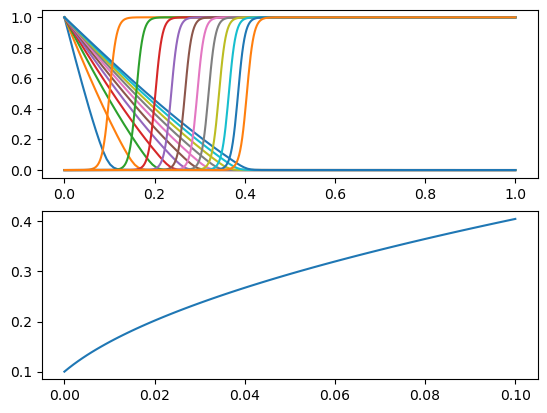

In [32]:
import numpy as np
from scipy.special import erf
from scipy.optimize import root_scalar

# Parameters
# ==========
# Number of grid points
Nphi = 431 + 1
NT = 128 + 1
# Size of domain in x
Lx = 1.0

# x phiii
# x-coordinate vector
x_phi = np.linspace(0, Lx, Nphi)
# Grid spacing in x
dx_phi = x_phi[1] - x_phi[0]

# x t
# x-coordinate vector

# x_t = np.linspace(0, Lx, NT)
x_t = np.linspace(0, Lx, NT)
# Grid spacing in x
dx_t = x_t[1] - x_t[0]

# Phase-field parameters # Issues atm
As = 128
eps = (1/128)
A = As*eps
D = 1.2/A

# Similarity solution parameter
def f_lam(x):
    return np.sqrt(np.pi)*x*np.exp(x**2)*erf(x) - 1.0
lam = root_scalar(f_lam, bracket=[0, 1]).root

# Initial interface position
h = 0.1
# Initial conditions for phi 
phi = 0.5*(1 + np.tanh((x_phi - h)/(2*eps)))

# Initial conditions for T
T = np.zeros(x_t.size)

T_1plus = np.log(2 * np.cosh((x_t[x_t>h] - h) / (2 * eps))) - (x_t[x_t>h] - h) / (2 * eps)
T_1minus = np.log(1+np.exp((x_t[x_t<h]-h)/eps))
Sv0 = (2*lam**2)/h

T[x_t<h] = 1.0 - erf(lam*x_t[x_t<h]/h)/erf(lam) + eps*Sv0*T_1minus # T0 + T1_minus
T[x_t>h] = eps*Sv0*T_1plus # T1_plus
dphi = np.zeros(x_phi.size)

# Storage arrays for time evolution
phi_save = np.zeros((Nphi, 101))
T_save = np.zeros((NT, 101))

# New Arrays
dphi_save = np.zeros((Nphi, 101))
dphi_interp_save = np.zeros((NT, 101))
T_interp_save = np.zeros((Nphi, 101))

phi_save[:, 0] = phi
T_save[:, 0] = T

# Time-stepping parameters
simtime = 0.0   # Current simulation time

dt = 0.8*(dx_phi)**2 # Time step
#dt = 104.8576*(dx_phi)**3


t_end = 0.1     # End simulation time
dt_save = t_end/100 # Interval for saving data

def D2(kappa, Nx):
    """
    Construct a second derivative matrix with empty
    top and bottom rows free for boundary conditions.
    Second derivative is multiplied by a constant `kappa`.
    """
    x = np.linspace(0, Lx, Nx)
    dx = x[1] - x[0]
    kappa = kappa/dx**2
    M = np.zeros((Nx, Nx))
    for i in range(1, Nx-1):
        M[i, i-1:i+2] = np.array([1, -2, 1])*kappa
    return M

# Construct left-hand side matrices
D2phi = D2(D, Nphi)
Lphi = np.eye(Nphi) - 0.5*dt*D2phi
D2T = D2(1.0, NT)
LT = np.eye(NT) - 0.5*dt*D2T

# Temporary arrays for time-stepping
rhs_T = np.zeros(NT)
rhs_phi = np.zeros(Nphi)

dphi = np.zeros(x_phi.size)
dphi_interp =  np.zeros(x_t.size)
T_interp = np.zeros(x_phi.size)
De2 = D/eps**2

iLphi = np.linalg.inv(Lphi)
iLT = np.linalg.inv(LT)

def step_time():
    global phi, T
    interp_func = interp1d(x_t, T, kind='linear')
    T_interp[:] = interp_func(x_phi) 
    rhs_phi[:] = dt*D2phi@phi + dt*(
        -De2*phi*(1 - phi)*(1 - 2*phi + A*T_interp)
    )
    rhs_phi[0] = 0.0
    dphi[:] = iLphi@rhs_phi # iLphi @ rhs OR  np.matmul(iLphi,rhs)
    phi += dphi
    interp_func2 = interp1d(x_phi, dphi, kind='linear')
    dphi_interp[:] = interp_func2(x_t) 
    rhs_T[:] = T + 0.5*dt*D2T@T + dphi_interp
    rhs_T[0] = 1.0
    T[:] = iLT@rhs_T
    return

import time

t1 = time.time()
# Main loop
while simtime < t_end:
    step_time()
    simtime += dt
    if simtime % dt_save < dt:
        print('Saving data at t = %.2e' % simtime)
        phi_save[:, int(simtime/dt_save)] = phi
        T_save[:, int(simtime/dt_save)] = T
        dphi_save[:, int(simtime/dt_save)] = dphi
        dphi_interp_save[:, int(simtime/dt_save)] = dphi_interp
        T_interp_save[:, int(simtime/dt_save)] = T_interp
t2 = time.time()
print('Elapsed time: %.2f seconds' % (t2 - t1))

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2)
ax = axs[0]
ax.plot(x_t, T_save[:,::10])
ax.plot(x_phi, phi_save[:,::10])

h_num = np.array([np.interp(0.5, phi_save[:,i], x_phi) for i in range(phi_save.shape[1])])
ax = axs[1]
ax.plot(np.linspace(0, t_end, phi_save.shape[1]), h_num)
plt.show()



# dphi Graph for comparison

(0.1, 0.2)

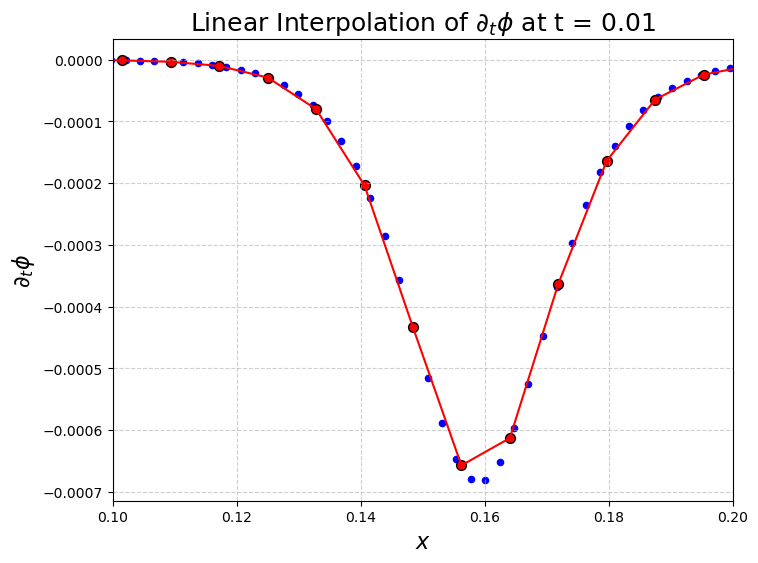

In [34]:
plt.figure(figsize=(8, 6))

plt.scatter(x_phi, dphi_save[:, 10], color='blue', s=20, label=r'Original $\partial_t \phi$')
plt.scatter(x_t, dphi_interp_save[:, 10], color='red', label=r'Interpolated $\partial_t \phi$', s=50, edgecolors='black')
plt.plot(x_t, dphi_interp_save[:, 10],'r')
#plt.plot(x_phi, dphi_save[:, 10], color='blue', linewidth=2, label=r'Original $\partial_t \phi$')


# Add labels and title
plt.xlabel(r'$x$', fontsize=16)
plt.ylabel(r'$\partial_t \phi$', fontsize=16)
plt.title(r'Linear Interpolation of $\partial_t \phi$ at t = 0.01', fontsize=18)

plt.grid(True, linestyle='--', alpha=0.6)



#plt.xlim([min(x_phi), max(x_phi)])
plt.xlim([0.1, 0.2])

#plt.savefig("Linear_Interpolation_phi.pdf", format="pdf")

# Interpolated T also

In [38]:
from scipy.optimize import fsolve
def lam(x):
    return np.sqrt(np.pi) * x * np.exp(x**2) * erf(x) - 1
lambd = fsolve(lam, 0.8)

h = 0.1
t0 = (h / (2 * lambd))**2  # Initial t0
t_end = 0.1 

t = np.linspace(t0, t_end+t0, 101)
h_a = 2*np.sqrt(t)*lambd

T_a = np.zeros([len(x_t),101])
i=0
while i<len(h_a): 
    h_now = h_a[i]
    mask = x_t < h_now
    T_a[mask,i] = 1.0 - erf(lambd*x_t[mask]/h_now)/erf(lambd)
    i = i+1

(0.0, 0.05)

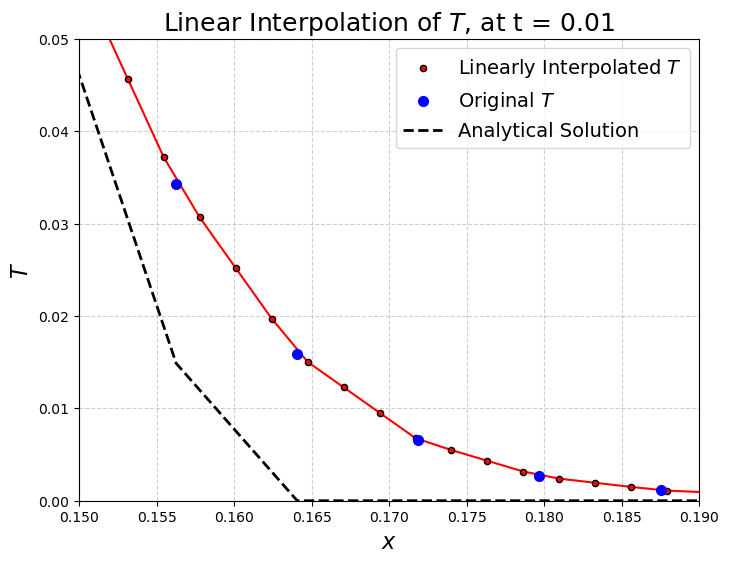

In [40]:
plt.figure(figsize=(8, 6))

plt.plot(x_phi, T_interp_save[:, 10],'r')

plt.scatter(x_phi, T_interp_save[:, 10], color='red', label=r'Linearly Interpolated $T$', s=20, edgecolors='black',  zorder=2)
#plt.scatter(x_phi, T_cubic_interp_save[:, 10], color='green', label=r'Interpolated $T$', s=20, edgecolors='black')
plt.scatter(x_t, T_save[:, 10], color='blue', linewidth=2, label=r'Original $T$',  zorder=3)

plt.plot(x_t, T_a[:, 10], 'black', linestyle = 'dashed', linewidth=2, label="Analytical Solution")


# Add labels and title
plt.xlabel(r'$x$', fontsize=16)
plt.ylabel(r'$T$', fontsize=16)
plt.title(r'Linear Interpolation of $T$, at t = 0.01', fontsize=18)

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=14)

#plt.xlim([min(x_phi), max(x_phi)])
plt.xlim([0.15, 0.19])
plt.ylim([0,0.05])

#plt.savefig("Linear_Interpolation_T.pdf", format="pdf")

# Same For Cubic 

Saving data at t = 1.00e-03
Saving data at t = 2.00e-03
Saving data at t = 3.00e-03
Saving data at t = 4.00e-03
Saving data at t = 5.00e-03
Saving data at t = 6.00e-03
Saving data at t = 7.00e-03
Saving data at t = 8.00e-03
Saving data at t = 9.00e-03
Saving data at t = 1.00e-02
Saving data at t = 1.10e-02
Saving data at t = 1.20e-02
Saving data at t = 1.30e-02
Saving data at t = 1.40e-02
Saving data at t = 1.50e-02
Saving data at t = 1.60e-02
Saving data at t = 1.70e-02
Saving data at t = 1.80e-02
Saving data at t = 1.90e-02
Saving data at t = 2.00e-02
Saving data at t = 2.10e-02
Saving data at t = 2.20e-02
Saving data at t = 2.30e-02
Saving data at t = 2.40e-02
Saving data at t = 2.50e-02
Saving data at t = 2.60e-02
Saving data at t = 2.70e-02
Saving data at t = 2.80e-02
Saving data at t = 2.90e-02
Saving data at t = 3.00e-02
Saving data at t = 3.10e-02
Saving data at t = 3.20e-02
Saving data at t = 3.30e-02
Saving data at t = 3.40e-02
Saving data at t = 3.50e-02
Saving data at t = 3

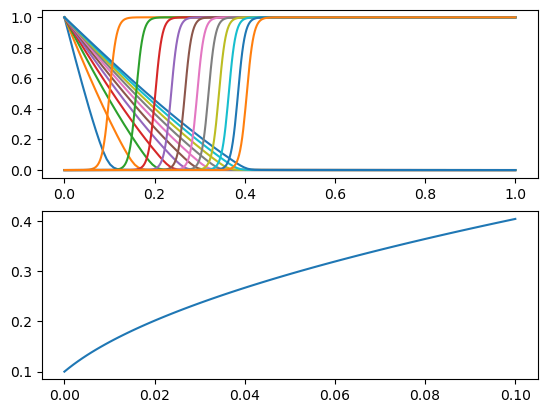

array([1.00000017e+00, 9.11828983e-01, 8.24070978e-01, 7.37133892e-01,
       6.51415478e-01, 5.67300593e-01, 4.85162937e-01, 4.05378775e-01,
       3.28371953e-01, 2.54739187e-01, 1.85565865e-01, 1.23090906e-01,
       7.15021065e-02, 3.59329747e-02, 1.58165983e-02, 6.31284217e-03,
       2.40018194e-03, 8.94166179e-04, 3.30494836e-04, 1.21793762e-04,
       4.48341364e-05, 1.64974478e-05, 6.06959864e-06, 2.23295186e-06,
       8.21466732e-07, 3.02202029e-07, 1.11174090e-07, 4.08986861e-08,
       1.50457890e-08, 5.53503687e-09, 2.03622629e-09, 7.49085791e-10,
       2.75573299e-10, 1.01377757e-10, 3.72948322e-11, 1.37200043e-11,
       5.04725159e-12, 1.85682343e-12, 6.83076251e-13, 2.51311447e-13,
       9.24143155e-14, 3.40417629e-14, 1.24855369e-14, 4.58870158e-15,
       1.70742384e-15, 6.40283941e-16, 2.13427980e-16, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [43]:
import numpy as np
from scipy.special import erf
from scipy.optimize import root_scalar
#from scipy.interpolate import interp1d
from scipy.interpolate import CubicHermiteSpline

# Parameters
# ==========
# Number of grid points
Nphi = 431 + 1
NT = 128 + 1
# Size of domain in x
Lx = 1.0

# x phiii
# x-coordinate vector
x_phi = np.linspace(0, Lx, Nphi)
# Grid spacing in x
dx_phi = x_phi[1] - x_phi[0]

# x t
# x-coordinate vector

# x_t = np.linspace(0, Lx, NT)
x_t = np.linspace(0, Lx, NT)
# Grid spacing in x
dx_t = x_t[1] - x_t[0]

# Phase-field parameters # Issues atm
As = 128
eps = (1/128)
A = As*eps
D = 1.2/A

# Similarity solution parameter
def f_lam(x):
    return np.sqrt(np.pi)*x*np.exp(x**2)*erf(x) - 1.0
lam = root_scalar(f_lam, bracket=[0, 1]).root

# Initial interface position
h = 0.1
# Initial conditions for phi 
phi = 0.5*(1 + np.tanh((x_phi - h)/(2*eps)))

# Initial conditions for T
T = np.zeros(x_t.size)

T_1plus = np.log(2 * np.cosh((x_t[x_t>h] - h) / (2 * eps))) - (x_t[x_t>h] - h) / (2 * eps)
T_1minus = np.log(1+np.exp((x_t[x_t<h]-h)/eps))
Sv0 = (2*lam**2)/h

T[x_t<h] = 1.0 - erf(lam*x_t[x_t<h]/h)/erf(lam) + eps*Sv0*T_1minus # T0 + T1_minus
T[x_t>h] = eps*Sv0*T_1plus # T1_plus
dphi = np.zeros(x_phi.size)

# Storage arrays for time evolution
phi_save = np.zeros((Nphi, 101))
T_save = np.zeros((NT, 101))
phi_save[:, 0] = phi
T_save[:, 0] = T

# Temp
dphi_cubic_interp_save = np.zeros((NT, 101))
T_cubic_interp_save = np.zeros((Nphi, 101))

# Time-stepping parameters
simtime = 0.0   # Current simulation time

dt = 0.8*(dx_phi)**2 # Time step
#dt = 104.8576*(dx_phi)**3


t_end = 0.1     # End simulation time
dt_save = t_end/100 # Interval for saving data

def D2(kappa, Nx):
    """
    Construct a second derivative matrix with empty
    top and bottom rows free for boundary conditions.
    Second derivative is multiplied by a constant `kappa`.
    """
    x = np.linspace(0, Lx, Nx)
    dx = x[1] - x[0]
    kappa = kappa/dx**2
    M = np.zeros((Nx, Nx))
    for i in range(1, Nx-1):
        M[i, i-1:i+2] = np.array([1, -2, 1])*kappa
    return M

# Construct left-hand side matrices
D2phi = D2(D, Nphi)
Lphi = np.eye(Nphi) - 0.5*dt*D2phi
D2T = D2(1.0, NT)
LT = np.eye(NT) - 0.5*dt*D2T

# Temporary arrays for time-stepping
rhs_T = np.zeros(NT)
rhs_phi = np.zeros(Nphi)

dphi = np.zeros(x_phi.size)
De2 = D/eps**2

iLphi = np.linalg.inv(Lphi)
iLT = np.linalg.inv(LT)

def step_time():
    global phi, T, dphi_interp, T_interp
    # New 
    dT_dx = np.gradient(T, x_t)

    interp_func = CubicHermiteSpline(x_t, T, dT_dx)
    T_interp[:] = interp_func(x_phi) 
    rhs_phi[:] = dt*D2phi@phi + dt*(
        -De2*phi*(1 - phi)*(1 - 2*phi + A*T_interp)
    )
    rhs_phi[0] = 0.0
    dphi[:] = iLphi@rhs_phi # iLphi @ rhs OR  np.matmul(iLphi,rhs)
    phi += dphi
    
    dphi_dx = np.gradient(dphi, x_phi)
    
    interp_func2 = CubicHermiteSpline(x_phi, dphi, dphi_dx)
    dphi_interp[:] = interp_func2(x_t) 
    rhs_T[:] = T + 0.5*dt*D2T@T + dphi_interp
    rhs_T[0] = 1.0
    T[:] = iLT@rhs_T
    return

import time

t1 = time.time()
# Main loop
while simtime < t_end:
    step_time()
    simtime += dt
    if simtime % dt_save < dt:
        print('Saving data at t = %.2e' % simtime)
        phi_save[:, int(simtime/dt_save)] = phi
        T_save[:, int(simtime/dt_save)] = T
        dphi_save[:, int(simtime/dt_save)] = dphi
        dphi_cubic_interp_save[:, int(simtime/dt_save)] = dphi_interp
        T_cubic_interp_save[:, int(simtime/dt_save)] = T_interp
t2 = time.time()
print('Elapsed time: %.2f seconds' % (t2 - t1))

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2)
ax = axs[0]
ax.plot(x_t, T_save[:,::10])
ax.plot(x_phi, phi_save[:,::10])


h_num = np.array([np.interp(0.5, phi_save[:,i], x_phi) for i in range(phi_save.shape[1])])
ax = axs[1]
ax.plot(np.linspace(0, t_end, phi_save.shape[1]), h_num)
plt.show()

T_save[:, 0]

(0.1, 0.2)

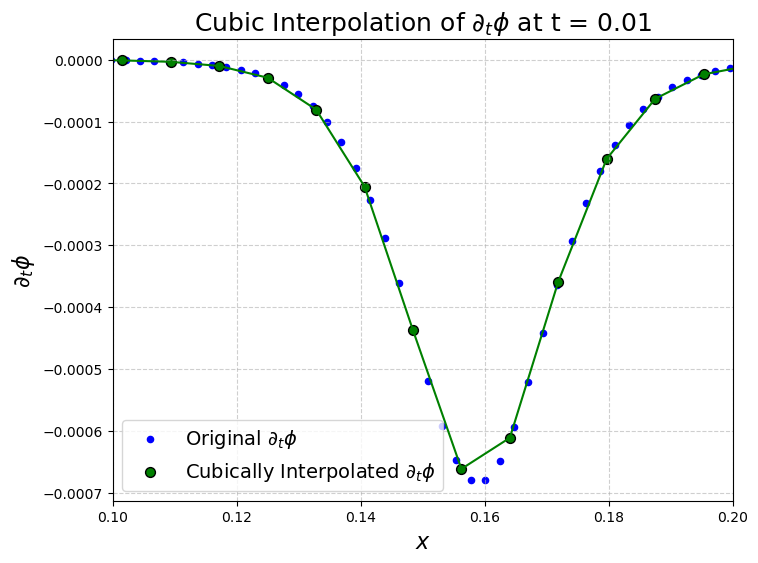

In [44]:
plt.figure(figsize=(8, 6))

plt.scatter(x_phi, dphi_save[:, 10], color='blue', s=20, label=r'Original $\partial_t \phi$')
plt.scatter(x_t, dphi_cubic_interp_save[:, 10], color='green', label=r'Cubically Interpolated $\partial_t \phi$', s=50, edgecolors='black')
plt.plot(x_t, dphi_cubic_interp_save[:, 10],'g')
#plt.plot(x_phi, dphi_save[:, 10], color='blue', linewidth=2, label=r'Original $\partial_t \phi$')


# Add labels and title
plt.xlabel(r'$x$', fontsize=16)
plt.ylabel(r'$\partial_t \phi$', fontsize=16)
plt.title(r'Cubic Interpolation of $\partial_t \phi$ at t = 0.01', fontsize=18)

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=14)

#plt.xlim([min(x_phi), max(x_phi)])
plt.xlim([0.1, 0.2])

#plt.savefig("Cubic_Interpolation_phi.pdf", format="pdf")

(0.0, 0.05)

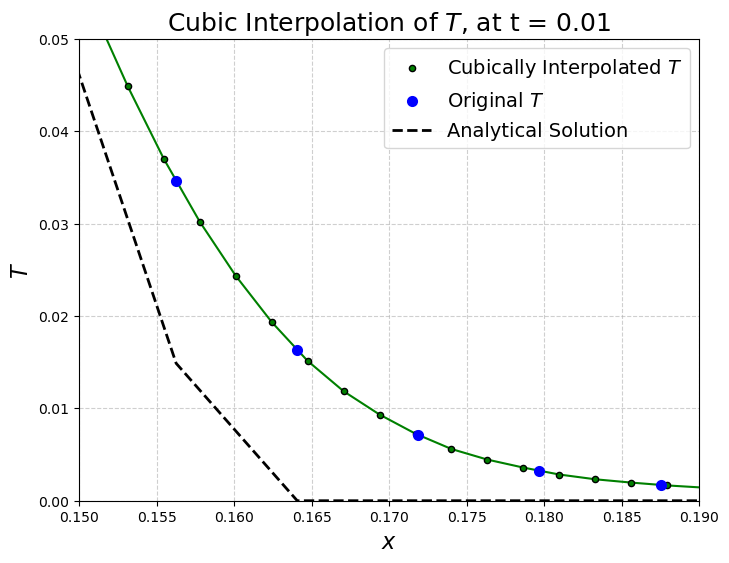

In [45]:
plt.figure(figsize=(8, 6))

plt.plot(x_phi, T_cubic_interp_save[:, 10],'green')

plt.scatter(x_phi, T_cubic_interp_save[:, 10], color='green', label=r'Cubically Interpolated $T$', s=20, edgecolors='black', zorder=2)
#plt.scatter(x_phi, T_cubic_interp_save[:, 10], color='green', label=r'Interpolated $T$', s=20, edgecolors='black')
plt.scatter(x_t, T_save[:, 10], color='blue', linewidth=2, label=r'Original $T$', zorder=3)

plt.plot(x_t, T_a[:, 10], 'black', linestyle = 'dashed', linewidth=2, label="Analytical Solution", zorder=2)


# Add labels and title
plt.xlabel(r'$x$', fontsize=16)
plt.ylabel(r'$T$', fontsize=16)
plt.title(r'Cubic Interpolation of $T$, at t = 0.01', fontsize=18)

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=14)

#plt.xlim([min(x_phi), max(x_phi)])
plt.xlim([0.15, 0.19])
plt.ylim([0,0.05])

#plt.savefig("Cubic_Interpolation_T.pdf", format="pdf")

# Direct Comparison

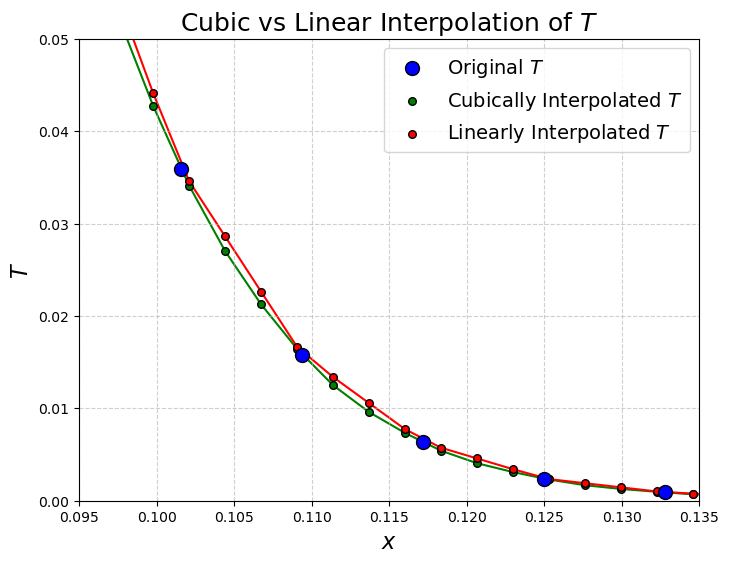

In [47]:
# Select a single time step (you can change the index)
plt.figure(figsize=(8, 6))

time_index = 0  # Example time step

# Original temperature profile
x_original = x_t
T_original = T_save[:, time_index]

# Cubic spline interpolation (already done in your code)
dT_dx = np.gradient(T_original, x_original)
cubic_interp_func = CubicHermiteSpline(x_original, T_original, dT_dx)
T_cubic_interp = cubic_interp_func(x_phi)

# Linear interpolation
linear_interp_func = interp1d(x_original, T_original, kind='linear')
T_linear_interp = linear_interp_func(x_phi)

# Plot the original and interpolated profiles


plt.plot(x_phi, T_cubic_interp,'green',  zorder=1)
plt.plot(x_phi, T_linear_interp,'red',  zorder=1)

plt.scatter(x_t, T_original, color='blue',  s=100, edgecolors='black', label=r'Original $T$',  zorder=3)

plt.scatter(x_phi,T_cubic_interp, color='green', label=r'Cubically Interpolated $T$', s=30, edgecolors='black',  zorder=2)
plt.scatter(x_phi,T_linear_interp, color='red', label=r'Linearly Interpolated $T$', s=30, edgecolors='black',  zorder=2)




plt.xlabel(r'$x$', fontsize=16)
plt.ylabel(r'$T$', fontsize=16)
plt.title(r'Cubic vs Linear Interpolation of $T$', fontsize=18)


plt.xlim([0.095, 0.135])
plt.ylim([0,0.05])


plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=14)

#plt.savefig("Interpolation_Comparison_T.pdf", format="pdf")

(0.05, 0.15)

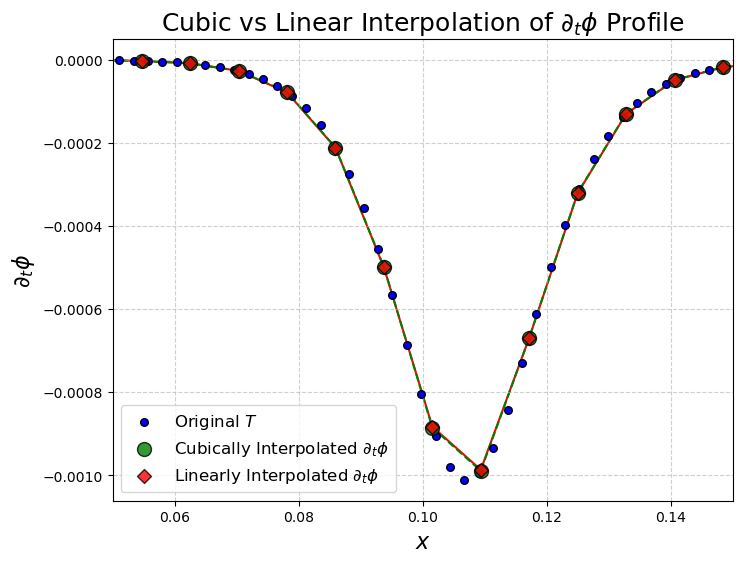

In [48]:
time_index = 1

# Original dphi profile
x_original_dphi = x_phi
dphi_original = dphi_save[:, time_index]

# Cubic Hermite interpolation for dphi
ddphi_dx = np.gradient(dphi_original, x_original_dphi)
cubic_dphi_interp_func = CubicHermiteSpline(x_original_dphi, dphi_original, ddphi_dx)
dphi_cubic_interp = cubic_dphi_interp_func(x_t)

# Linear interpolation for dphi
linear_dphi_interp_func = interp1d(x_original_dphi, dphi_original, kind='linear')
dphi_linear_interp = linear_dphi_interp_func(x_t)

# Plot the original and interpolated profiles
plt.figure(figsize=(8, 6))

plt.plot(x_t, dphi_linear_interp, linestyle='-', color='red',  zorder=1)
plt.plot(x_t, dphi_cubic_interp, linestyle='--', color='green',  zorder=1)

plt.scatter(x_phi, dphi_original, color='blue',  s=30, edgecolors='black', label=r'Original $T$',  zorder=2)

plt.scatter(x_t, dphi_cubic_interp, color='green', label=r'Cubically Interpolated $\partial_t\phi$', 
            s=100, edgecolors='black', marker='o', alpha=0.8, zorder=3)
plt.scatter(x_t, dphi_linear_interp, color='red', label=r'Linearly Interpolated $\partial_t\phi$', 
            s=50, edgecolors='black', marker='D', alpha=0.8, zorder=4)




plt.xlabel(r'$x$', fontsize=16)
plt.ylabel(r'$\partial_t\phi$', fontsize=16)
plt.title(r'Cubic vs Linear Interpolation of $\partial_t\phi$ Profile' , fontsize=18)

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, loc = 'lower left')

plt.xlim([0.05, 0.15])


#plt.savefig("Interpolation_Comparison_phi.pdf", format="pdf")

# 100 small time steps 

Saving data at t = 1.01e-03
Saving data at t = 2.00e-03
Saving data at t = 3.01e-03
Saving data at t = 4.01e-03
Saving data at t = 5.00e-03
Saving data at t = 6.00e-03
Saving data at t = 7.00e-03
Saving data at t = 8.00e-03
Saving data at t = 9.00e-03
Saving data at t = 1.00e-02
Saving data at t = 1.10e-02
Saving data at t = 1.20e-02
Saving data at t = 1.30e-02
Saving data at t = 1.40e-02
Saving data at t = 1.50e-02
Saving data at t = 1.60e-02
Saving data at t = 1.70e-02
Saving data at t = 1.80e-02
Saving data at t = 1.90e-02
Saving data at t = 2.00e-02
Saving data at t = 2.10e-02
Saving data at t = 2.20e-02
Saving data at t = 2.30e-02
Saving data at t = 2.40e-02
Saving data at t = 2.50e-02
Saving data at t = 2.60e-02
Saving data at t = 2.70e-02
Saving data at t = 2.80e-02
Saving data at t = 2.90e-02
Saving data at t = 3.00e-02
Saving data at t = 3.10e-02
Saving data at t = 3.20e-02
Saving data at t = 3.30e-02
Saving data at t = 3.40e-02
Saving data at t = 3.50e-02
Saving data at t = 3

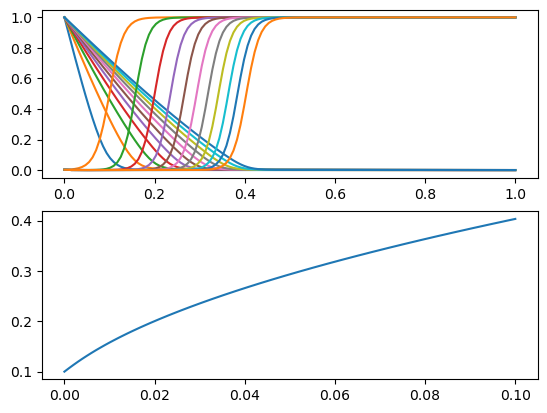

In [50]:
import numpy as np
from scipy.special import erf
from scipy.optimize import root_scalar

# Parameters
# ==========
# Number of grid points
Nphi = 128 + 1
NT = 128 + 1
# Size of domain in x
Lx = 1.0

# x phiii
# x-coordinate vector
x_phi = np.linspace(0, Lx, Nphi)
# Grid spacing in x
dx_phi = x_phi[1] - x_phi[0]

# x_t = np.linspace(0, Lx, NT)
x_t = np.linspace(0, Lx, NT)
# Grid spacing in x
dx_t = x_t[1] - x_t[0]

# Phase-field parameters # Issues atm
As = 128
eps = 2*dx_phi
A = As*eps
D = 1.2/A

# Similarity solution parameter
def f_lam(x):
    return np.sqrt(np.pi)*x*np.exp(x**2)*erf(x) - 1.0
lam = root_scalar(f_lam, bracket=[0, 1]).root

# Initial interface position
h = 0.1
# Initial conditions for phi 
phi = 0.5*(1 + np.tanh((x_phi - h)/(2*eps)))

# Initial conditions for T
T = np.zeros(x_t.size)

T_1plus = np.log(2 * np.cosh((x_t[x_t>h] - h) / (2 * eps))) - (x_t[x_t>h] - h) / (2 * eps)
T_1minus = np.log(1+np.exp((x_t[x_t<h]-h)/eps))
Sv0 = (2*lam**2)/h

T[x_t<h] = 1.0 - erf(lam*x_t[x_t<h]/h)/erf(lam) + eps*Sv0*T_1minus # T0 + T1_minus
T[x_t>h] = eps*Sv0*T_1plus # T1_plus
dphi = np.zeros(x_phi.size)

# Storage arrays for time evolution
phi_save = np.zeros((Nphi, 101))
T_save = np.zeros((NT, 101))
phi_save[:, 0] = phi
T_save[:, 0] = T

t_end = 0.1     # End simulation time
dt_save = t_end/100 # Interval for saving data

def D2(kappa, Nx):
    """
    Construct a second derivative matrix with empty
    top and bottom rows free for boundary conditions.
    Second derivative is multiplied by a constant `kappa`.
    """
    x = np.linspace(0, Lx, Nx)
    dx = x[1] - x[0]
    kappa = kappa/dx**2
    M = np.zeros((Nx, Nx))
    for i in range(1, Nx-1):
        M[i, i-1:i+2] = np.array([1, -2, 1])*kappa
    return M

# Construct left-hand side matrices
D2phi = D2(D, Nphi)
D2T = D2(1.0, NT)

# Temporary arrays for time-stepping
rhs_T = np.zeros(NT)
rhs_phi = np.zeros(Nphi)

dphi = np.zeros(x_phi.size)
De2 = D/eps**2

def step_time():
    global phi, T
    interp_func = interp1d(x_t, T, kind='linear')
    T_interp = interp_func(x_phi) 
    rhs_phi[:] = dt*D2phi@phi + dt*(
        -De2*phi*(1 - phi)*(1 - 2*phi + A*T_interp)
    )
    rhs_phi[0] = 0.0
    dphi[:] = iLphi@rhs_phi # iLphi @ rhs OR  np.matmul(iLphi,rhs)
    phi += dphi
    interp_func2 = interp1d(x_phi, dphi, kind='linear')
    dPhi_interp = interp_func2(x_t) 
    rhs_T[:] = T + 0.5*dt*D2T@T + dPhi_interp
    rhs_T[0] = 1.0
    T[:] = iLT@rhs_T
    return

import time

t1 = time.time()
# Main loop

# 100 small time steps
initial = 0
dt = 5e-5*(1/1000)

Lphi = np.eye(Nphi) - 0.5*dt*D2phi
LT = np.eye(NT) - 0.5*dt*D2T
iLphi = np.linalg.inv(Lphi)
iLT = np.linalg.inv(LT)

while initial < 100:
    step_time()
    initial += 1
    phi_save[:, initial] = phi
    T_save[:, initial] = T

T = T_save[:,-1]
phi = phi_save[:,-1]

simtime = dt*100
#simtime = 0

dt = 5e-5

Lphi = np.eye(Nphi) - 0.5*dt*D2phi
LT = np.eye(NT) - 0.5*dt*D2T
iLphi = np.linalg.inv(Lphi)
iLT = np.linalg.inv(LT)

while simtime < t_end:
    step_time()
    simtime += dt
    if simtime % dt_save < dt:
       print('Saving data at t = %.2e' % simtime)
       phi_save[:, int(simtime/dt_save)] = phi
       T_save[:, int(simtime/dt_save)] = T
t2 = time.time()
print('Elapsed time: %.2f seconds' % (t2 - t1))

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2)
ax = axs[0]
ax.plot(x_t, T_save[:,::10])
ax.plot(x_phi, phi_save[:,::10])

h_num = np.array([np.interp(0.5, phi_save[:,i], x_phi) for i in range(phi_save.shape[1])])
ax = axs[1]
ax.plot(np.linspace(0, t_end, phi_save.shape[1]), h_num)
plt.show()

In [51]:
#np.savez('1000_steps', T=T_save, phi=phi_save, dt=dt, eps=eps, h_num=h_num)
